In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE

import main
drive_path = r"W:\VEIDB/"
data_path = r"Z:\Data"
# data_path =r"V:\Data/"
# data_path =r"W:\Data/"

ft = main.load(drive_path, data_path)

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('dark')

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [3]:
from ephys import neuropixels_utils
from pathlib import Path
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import ndimage

In [4]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

In [54]:
exp_id = '01588'
lfp_path = r'V:\Data\01589\neuropixels\20211020\spikeGLX\0016_OPTS_0001_g0_t0.imec.lf.bin'
# lfp_path = r'V:\Data\01588\neuropixel\20211022\spikeGLX\OPTS_0014_g0_t0.imec.lf.bin'


In [55]:
lfps = neuropixels_utils.extract_analog(Path(lfp_path), channels=range(384))


nChan: 385, nFileSamp: 1147405


In [56]:
mean_lfp = np.mean(lfps, axis=0) - np.mean(lfps)
mean_lfp = np.mean((lfps.T-np.mean(lfps, axis=1)).T, axis=0)
lfp_std = np.std(mean_lfp)

lower_bound = -lfp_std*6
upper_bound = lfp_std*6
values_below = mean_lfp<lower_bound
values_upper = mean_lfp>upper_bound
transitions_below =  np.where(np.diff(values_below.astype(int))>0)[0]
transitions_upper = np.where(np.diff(values_upper.astype(int))>0)[0]

In [57]:
below_idx, upper_idx = 0, 0
curr = 0
transitions_below_filt = []
transitions_upper_filt = []
below=False

while below_idx <= len(transitions_below) and upper_idx < len(transitions_upper):
    if below == True:
        if transitions_upper[upper_idx] > curr:
            transitions_upper_filt.append(transitions_upper[upper_idx])
            curr = transitions_upper[upper_idx]
            below = False
        upper_idx += 1
    else:
        if transitions_below[below_idx] > curr:
            transitions_below_filt.append(transitions_below[below_idx])
            curr = transitions_below[below_idx]
            below = True
        below_idx += 1

In [58]:
print(len(transitions_upper_filt), len(transitions_below_filt))

100 100


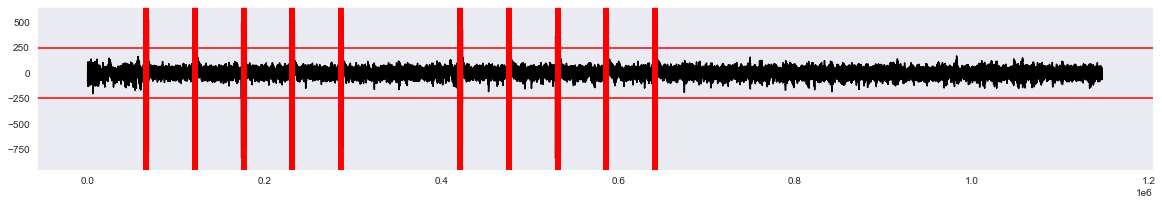

In [60]:
plt.subplots(1, 1, figsize=(20, 3))

plt.plot(mean_lfp, c='k') # [120000:124000], [120200:120300]
for transition in transitions_below:
    plt.axvline(transition, c='r')
for transition in transitions_upper:
    plt.axvline(transition, c='r')
plt.axhline(lfp_std*6, c='r')
plt.axhline(-lfp_std*6, c='r')
# plt.xlim(62500, 63000)
plt.show()